In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import matplotlib.pyplot as plt

print(os.listdir("../input"))

['sample_submission.csv', 'test', 'train.csv']


In [2]:
# Fix seeds
from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

#read data
float_data = pd.read_csv("../input/train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

In [3]:
#create feature
def extract_features(z):
     return np.c_[z.mean(axis=1), 
                  np.transpose(np.percentile(np.abs(z), q=[0, 50, 75, 100], axis=1)),
                  z.std(axis=1)]
def extract_features_roll(z):
    
    df_z = pd.DataFrame(z)
    
    df_roll_std_50 = df_z.rolling(50, axis=1).std().values[:, 49:]
    df_roll_skew_50 = df_z.rolling(50, axis=1).skew().values[:, 49:]
    df_roll_kurt_50 = df_z.rolling(50, axis=1).kurt().values[:, 49:]
    df_roll_mean_50 = df_z.rolling(50, axis=1).mean().values[:, 49:]
    
    df_roll_std_100 = df_z.rolling(100, axis=1).std().values[:, 99:]
    df_roll_skew_100 = df_z.rolling(100, axis=1).skew().values[:, 99:]
    df_roll_kurt_100 = df_z.rolling(100, axis=1).kurt().values[:, 99:]
    df_roll_mean_100 = df_z.rolling(100, axis=1).mean().values[:, 99:]
    
    return np.c_[#np.quantile(df_roll_std, 0.05, axis=1),
                 #np.quantile(df_roll_std, 0.10, axis=1),
                 #np.quantile(df_roll_skew, 0.05, axis=1),
                 #np.quantile(df_roll_skew, 0.10, axis=1),
                 #np.quantile(df_roll_kurt, 0.05, axis=1),
                 #np.quantile(df_roll_kurt, 0.10, axis=1),
                 np.transpose(np.quantile(df_roll_std_50, q=[0.01, 0.05, 0.10, 0.95, 0.99], axis=1)),
                 np.transpose(np.quantile(df_roll_std_100, q=[0.01, 0.05, 0.10, 0.95, 0.99], axis=1)),
                 np.transpose(np.quantile(df_roll_skew_50, q=[0.05, 0.10], axis=1)),
                 np.transpose(np.quantile(df_roll_skew_100, q=[0.05, 0.10], axis=1)),
                 np.transpose(np.quantile(df_roll_kurt_50, q=[0.05, 0.10], axis=1)),
                 np.transpose(np.quantile(df_roll_kurt_100, q=[0.05, 0.10], axis=1)),
                 np.transpose(np.quantile(df_roll_mean_50, q=[0.05, 0.10, 0.95], axis=1)),
                 np.transpose(np.quantile(df_roll_mean_100, q=[0.05, 0.10, 0.95], axis=1)),
                ]

def create_X(x, last_index=None, n_steps=150, step_length=1000):
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    # MY CHANGE: This doesn't fix things, I get the same errors
    #temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1).astype(np.float32) - 5 ) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations. 
    return np.c_[extract_features(temp)]#,
                 #extract_features(temp[:, -step_length // 10:]),
                 #extract_features(temp[:, -step_length // 100:])]
                 #extract_features_roll(temp)]

In [4]:
# Query "create_X" to figure out the number of features
n_features = create_X(float_data[0:150000]).shape[1]
print("Our RNN is based on %i features"% n_features)

# The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
# the "time_to_failure" serves as target, while the features are created by the function "create_X".
def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield samples, targets
        
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 50085877
float_data[second_earthquake, 1]

# Initialize generators
# train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
valid_gen = generator(float_data, batch_size=batch_size, max_index=second_earthquake)


Our RNN is based on 6 features


In [13]:
#define model
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.optimizers import adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

cp = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3),
      EarlyStopping(monitor='val_loss', patience = 3, verbose = 1),]

model = Sequential()
model.add(GRU(48, input_shape=(None, n_features)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 48)                7920      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                490       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 8,421
Trainable params: 8,421
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer=adam(lr=0.0005), loss="mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=15,
                              verbose=1,
                              callbacks=cp,
                              validation_data=valid_gen,
                              validation_steps=200)

Epoch 1/15
1000/1000 [==============================] - 237s 237ms/step - loss: 2.4733 - val_loss: 1.8428
Epoch 2/15
1000/1000 [==============================] - 234s 234ms/step - loss: 2.1391 - val_loss: 1.9272
Epoch 3/15
1000/1000 [==============================] - 232s 232ms/step - loss: 2.1247 - val_loss: 1.6806
Epoch 4/15
1000/1000 [==============================] - 229s 229ms/step - loss: 2.1390 - val_loss: 1.6916
Epoch 5/15
1000/1000 [==============================] - 227s 227ms/step - loss: 2.1075 - val_loss: 1.9084
Epoch 6/15
1000/1000 [==============================] - 228s 228ms/step - loss: 2.1073 - val_loss: 1.8353
Epoch 00006: early stopping


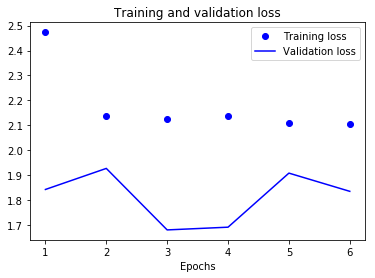

In [15]:
# Visualize accuracies
import matplotlib.pyplot as plt

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

perf_plot(history)

In [16]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real time')
    plt.plot(predicted, color='blue',label='Predicted time')
    plt.legend()
    plt.show()

valid_data = float_data[:second_earthquake]
x_valid = valid_data[:,0]
y_valid = valid_data[:,1]

valid_len = int(np.floor(second_earthquake/150000))
print(valid_len)
real_y = np.zeros(valid_len, dtype=float)
pred = np.zeros(valid_len, dtype=float)
for i in range(1,valid_len):
    test = x_valid[(i-1)*150000:i*150000]
    real_y[i] = y_valid[i*150000]
    pred[i] = model.predict(np.expand_dims(create_X(test), 0))
print(x_valid[:10])
print(y_valid[:10])
print(real_y[:10])
print(pred)

333
[12.  6.  8.  5.  8.  8.  9.  7. -5.  3.]
[1.4691 1.4691 1.4691 1.4691 1.4691 1.4691 1.4691 1.4691 1.4691 1.4691]
[0.         1.43079722 1.39149892 1.35319614 1.31379783 1.27439952
 1.23609674 1.19679844 1.15849566 1.11909735]
[0.         4.33407259 5.02600861 3.20047212 3.52311492 4.06690884
 4.31295109 3.98037744 5.54829407 2.53232121 3.71890783 3.72873616
 2.56297946 2.78944802 3.58365417 5.05512571 3.53742003 3.79673004
 3.93726063 3.21614909 4.39774704 2.27671576 2.45337677 2.60965848
 4.01690197 3.42140007 3.36031532 4.29458904 3.90716147 3.40412688
 1.09885073 1.26364994 2.73116016 6.57743168 8.48938084 8.7974844
 8.78509331 9.00778008 8.78684425 8.85896587 8.94367027 8.88412666
 8.66822243 8.89569759 8.83296967 9.01587677 8.88241768 8.77095795
 9.07626534 9.00812054 9.04101562 9.10495567 9.00642109 8.94750404
 9.05512428 9.06202126 8.91307449 9.19620609 9.07185936 9.14439201
 8.98347569 8.81551552 9.08850861 8.95508671 9.07607651 8.58288288
 8.73930454 8.7798214  8.74756622

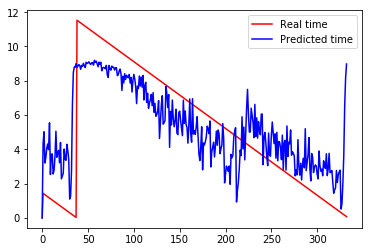

In [17]:
# Visualizing the results
plot_predictions(real_y,pred)

In [18]:
from sklearn.metrics import mean_absolute_error
print(f'Valid MAE: {mean_absolute_error(real_y,pred):.4f}')

Valid MAE: 1.8004


4194


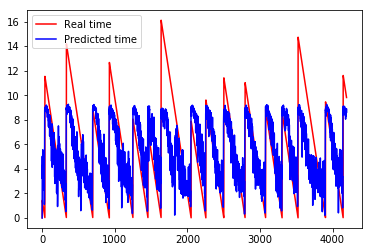

All MAE: 2.0797


In [19]:
x_all = float_data[:,0]
y_all = float_data[:,1]

all_len = int(np.floor(len(float_data)/150000))
print(all_len)
real_all_y = np.zeros(all_len, dtype=float)
pred_all = np.zeros(all_len, dtype=float)
for i in range(1,all_len):
    test = x_all[(i-1)*150000:i*150000]
    real_all_y[i] = y_all[i*150000]
    pred_all[i] = model.predict(np.expand_dims(create_X(test), 0))

# Visualizing the results of all data
plot_predictions(real_all_y,pred_all)
print(f'All MAE: {mean_absolute_error(real_all_y,pred_all):.4f}')

In [20]:
# Load submission file
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = model.predict(np.expand_dims(create_X(x), 0))

submission.head()

# Save
submission.to_csv('submission.csv')

100%|██████████| 2624/2624 [01:52<00:00, 23.36it/s]
